# Minimum CVaR optimisation with risk budgetting

The objective of this program is to maximise the sharpe ratio of the portfolio such that all stocks have a weight allocation of at least min_weight and a maximum weight allocation of 1. Moreover, each stock cannot have more than an x percentage contribution to the total portfolio volatility. 

The package scipy.optimize can only minimise the objective function. Hence, the negative Sharpe Ratio is minimised. 

### Packages

In [128]:
import pandas as pd   
import numpy as np
import matplotlib.pyplot as plt
import pandas_datareader as dr 
from datetime import datetime
from scipy.optimize import minimize
from scipy.stats import norm

In [129]:
# packages installation anaconda + version used
# conda install pandas=1.2.2
# conda install pandas-datareader=0.9.0
# conda install scipy=1.6.1
# conda install openpyxl=3.0.6

### Input Variables

In [130]:
rf = 0.0156 #Check yield of 10 year US TBill
min_weight = 0.025
max_weight = 1
max_risk_contribution = 0.1

# Monte carlo -> for comparison to the optimal portfolio
number_of_portfolios = 10000

### Scraping Data

In [131]:
# Initialize Input Data
start_date = '2020-01-01'
today = datetime.today().strftime('%Y-%m-%d')
assets = pd.read_excel ('SigmaInput.xlsx')["Ticker"]

# Create df for adjusted close prices of portfolio
prices = pd.DataFrame()

for stock in assets:
    prices[stock] = dr.data.get_data_yahoo(stock, start =start_date, end =today)['Adj Close']

#Show the daily simple return
return_stocks = (prices/prices.shift(1))-1
#return_stocks.to_excel('PortfolioReturns.xlsx')

In [132]:
cov_matrix = return_stocks.cov()*252 
cov_matrix_np = cov_matrix.to_numpy()
equally_weighted = [1/len(assets),]*len(assets)

### Calculation of Portfolio statistics

In [133]:
# function to obtain portfolio- return,volatility,sharpe.
def get_p_data(weights):
        weights = np.array(weights)
        p_return= np.sum(return_stocks.mean()*weights) * 252
        p_volatility = np.sqrt(np.dot(weights.T, np.dot(return_stocks.cov()*252, weights)))
        p_sharpe = (p_return-rf)/p_volatility 
        p_CVaR5 = (5/100)**-1 * norm.pdf(norm.ppf(5/100))*p_volatility - p_return
        return np.array([p_return, p_volatility, p_sharpe, p_CVaR5])

def get_p_volatility(weights):
        weights = np.array(weights)
        p_volatility = np.sqrt(np.dot(weights.T, np.dot(return_stocks.cov()*252, weights)))
        return p_volatility

In [134]:
# function to get the marginal volatilities 
def marginal_volatilities(weights, cov_matrix_np):
    volatility_p = get_p_volatility(weights)
    print("portfolio volatility = ", volatility_p )
        
    for i in range(len(weights)):
        cov_weight_i = (weights[i] * np.dot(cov_matrix_np, weights)[i])/volatility_p 
        print("i = ", i , "risk contribution = ", cov_weight_i)

### Risk budgetting

Let $w$ be the vector of the weight allocation and let $\Sigma$ be the covariance matrix. Then,

1. Portfolio volatility: $\sqrt(w\Sigma w^t)$
2. Risk contribution asset i: $w_i*\frac{(\Sigma w)_i}{\sqrt(w\Sigma w^t)}$

The following constraints needs to be included such that the individual risk contributions of each stock $i$ are below maximum contribution M:

$w_i*\frac{(\Sigma w)_i}{\sqrt(w\Sigma w^t)} \leq M\sqrt(w\Sigma w^t)$

Rewriting gives:

$M\sqrt(w\Sigma w^t) - w_i*\frac{(\Sigma w)_i}{\sqrt(w\Sigma w^t)} \geq 0$



In [135]:
# args is defined as the tuple of arguments with first the max risk contribution and then the covariance matrix
def risk_budget(weights, i, *args):
    volatility_p = get_p_volatility(weights)
    dot_product = np.dot(args[1], weights)
    dot_product_value = np.take(dot_product, i)
    q = args[0]*volatility_p - (weights[i]*dot_product_value/volatility_p)
    return q

### Constraints

### Conditional Value at Risk

Conditional Value at Risk (CVaR), also known as the expected shortfall, is a risk assessment measure that quantifies the amount of tail risk an investment portfolio has. CVaR is derived by taking a weighted average of the “extreme” losses in the tail of the distribution of possible returns, beyond the value at risk (VaR) cutoff point. Conditional value at risk is used in portfolio optimization for effective risk management. The use of CVaR as opposed to just VaR tends to lead to a more conservative approach in terms of risk exposure.

The "expected shortfall at 5% level" is the expected return on the portfolio in the worst 5% of cases. The expected shortfall is an alternative to VaR that is more sensitive to the shape of the tail of the loss distribution. The 5% level is used in the optimization method below.

$ CVaR_{p,\alpha} = \alpha^{-1}*\varphi(\phi^{-1}(\alpha))\sigma_{p}-\mu_{p} $

where,
<br> $\varphi(z)$ = standard normal density function
<br> $\phi^{-1}(\alpha)$ = $\alpha$ quantile of standard normal distribution
<br> $\sigma_{p}$ = volatility of portfolio
<br> $\mu_{p}$ = return of portfolio

In [150]:
# function to get negative Sharpe Ratio.
def CVaR(weights):
        return get_p_data(weights)[3]

# function to check if sum investment is 1.
def check_sum(weights):
        return np.sum(weights) -1

# constraint for objective function-np
constraints_list = list()

#  sum investment is 1
constraints_list.append({'type':'eq', 'fun':check_sum})

# individual risk constributions
a = list(range(len(assets)))
for i in a:
    constraints_list.append({'type':'ineq', 'fun': risk_budget, 'args':(i, max_risk_contribution, cov_matrix_np)})  

constraints = tuple(constraints_list)

# weight boundaries
bounds = ((min_weight,max_weight),)*len(assets)

# equally weighted portfolio / starting point of Sequantial least Squares programming method.
equally_weighted = [1/len(assets),]*len(assets)

### Optimisation

In [144]:
optimal_result = minimize(CVaR, equally_weighted, method='SLSQP', bounds=bounds, constraints = constraints)
optimal_weights = optimal_result.x
optimal_portfolio = get_p_data(optimal_result.x)

optimal_return = np.round(optimal_portfolio[0],2)
optimal_volatility = np.round(optimal_portfolio[1],2)
optimal_sharpe = np.round(optimal_portfolio[2],2)
min_CVaR = np.round(optimal_portfolio[3],2)
overview = pd.DataFrame({'Assets': assets,'Weight (%)': np.round(optimal_weights*100,2)}, columns=['Assets', 'Weight (%)']).T

statistic = ['Number of Assets', 'Expected Return', 'Expected Volatility', 'Expected Sharpe', 'Expected CVaR']
data = [np.round(len(assets),0), optimal_return, optimal_volatility, optimal_sharpe, optimal_CVaR]
table = pd.DataFrame(data, statistic)

### Generating Random Portfolios

In [145]:
# Initialization of arrays we will use for n number of random portfolios. 
portfolio_returns = []
portfolio_sd = []
portfolio_sharpe = []
portfolio_weights = []
portfolio_CVaR = []

# Create n number of portfolios with random weights allocations and perform calculations for portfolio data. 
for portfolio in range (number_of_portfolios):
  
    # Generate random weights vector with lengts of number of assets
    weights = weights = max_weight * np.random.random_sample((len(assets))) + min_weight
    weights = weights / np.sum(weights)
  
    # Calculate Annual Return of random portfolios
    annual_return = np.sum((return_stocks.mean() * weights) * 252)
    portfolio_returns.append(annual_return)
  
    # Calculate Covariance Matrix for assets in random portfolios
    cov_matrix_portfolio = (return_stocks.cov()) * 252
  
    # Calculate Volatility/SD of random portfolios
    portfolio_variance = np.dot(weights.T,np.dot(cov_matrix_portfolio, weights))
    portfolio_standard_deviation = np.sqrt(portfolio_variance) 
    portfolio_sd.append(portfolio_standard_deviation)
  
    # Calculate Sharpe's of random portfolios
    sharpe_ratio = ((annual_return - rf)/portfolio_standard_deviation)
    portfolio_sharpe.append(sharpe_ratio)
  
    # Calculate CVaRs of random portfolios for alpha = 0.05
    portfolio_CVaR5 = (5/100)**-1 * norm.pdf(norm.ppf(5/100))*portfolio_standard_deviation - annual_return
    portfolio_CVaR.append(portfolio_CVaR5)
    
    # Add random portfolio weights to weight array of portfolios.
    portfolio_weights.append(weights)

# Turn portfolio arrays into numpy arrays. 
portfolio_sd = np.array(portfolio_sd)
portfolio_returns = np.array(portfolio_returns)
portfolio_sharpe = np.array(portfolio_sharpe)
portfolio_CVaR = np.array(portfolio_CVaR)

## Results

In [146]:
print(overview)
overview.to_excel('minCVaR_Optimisation.xlsx')
print(table)

                0      1    2    3       4    5     6    7    8    9   ...  \
Assets      HEN.DE  AD.AS  DHI   MA  ALV.DE  JPM  EQIX  MDT  NVO  UNH  ...   
Weight (%)     2.5  14.08  2.5  2.5     2.5  2.5   2.5  2.5  2.5  2.5  ...   

              17   18    19       20   21      22    23     24    25    26  
Assets      NFLX  ETN  NVDA  PHIA.AS  SAP  KER.PA  SPGI  TCEHY  AMAT   TMO  
Weight (%)  9.65  2.5  5.71      2.5  2.5     2.5   2.5   9.29   2.5  6.27  

[2 rows x 27 columns]
                         0
Number of Assets     27.00
Expected Return       0.34
Expected Volatility   0.26
Expected Sharpe       1.25
Expected CVaR        -0.73


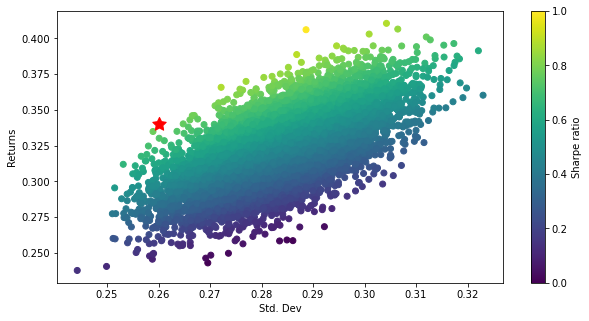

In [147]:
# Plot Return vs SD
plt.figure(figsize=(10, 5))
plt.scatter(portfolio_sd, portfolio_returns, c=portfolio_returns / portfolio_sd)
plt.scatter(optimal_volatility, optimal_return, s=200, c='red', marker=(5, 1))
plt.xlabel('Std. Dev')
plt.ylabel('Returns')
plt.colorbar(label='Sharpe ratio')

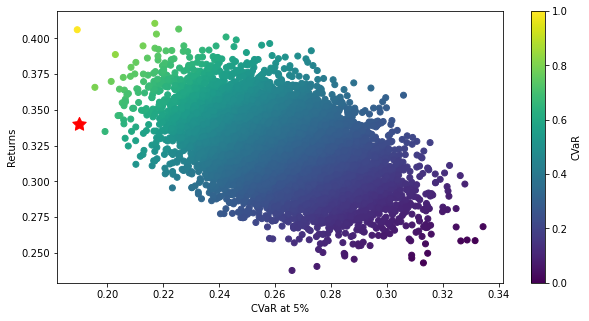

In [148]:
# Plot Return vs CVaR5
plt.figure(figsize=(10, 5))
plt.scatter(portfolio_CVaR, portfolio_returns, c=portfolio_returns / portfolio_CVaR)
plt.scatter(min_CVaR, optimal_return, s=200, c='red', marker=(5, 1))
plt.xlabel('CVaR at 5%')
plt.ylabel('Returns')
plt.colorbar(label='CVaR')

### Overview of Risk Contribution for Risk Budgetting

In [151]:
marginal_volatilities(optimal_weights, cov_matrix_np)

portfolio volatility =  0.25646000401509805
i =  0 risk contribution =  0.003867111743873257
i =  1 risk contribution =  0.011890864734287217
i =  2 risk contribution =  0.009428924474749996
i =  3 risk contribution =  0.009021102986380735
i =  4 risk contribution =  0.006047011041460346
i =  5 risk contribution =  0.008396301049583364
i =  6 risk contribution =  0.00654913206375099
i =  7 risk contribution =  0.007029457102398112
i =  8 risk contribution =  0.0047647951354699
i =  9 risk contribution =  0.008236417840450637
i =  10 risk contribution =  0.008443333096104552
i =  11 risk contribution =  0.00640152797409801
i =  12 risk contribution =  0.009457712860396275
i =  13 risk contribution =  0.005568915778078496
i =  14 risk contribution =  0.0036172033181228677
i =  15 risk contribution =  0.004519699832580695
i =  16 risk contribution =  0.004192403370214491
i =  17 risk contribution =  0.025632371656267833
i =  18 risk contribution =  0.008729433829849802
i =  19 risk contri